<a href="https://colab.research.google.com/github/stephen-osullivan/sentiment-classification-app/blob/main/notebooks/imdb_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install -q datasets scikit-learn joblib matplotlib wordcloud

This notebook was used to feel through the dataset and train the initial sentiment classification model.

In [18]:
from datasets import load_dataset

dataset = load_dataset("imdb")

train_ds = dataset["train"].to_pandas()
test_ds = dataset["test"].to_pandas()

print(train_ds)

                                                    text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]


In [21]:
#train and test have 25000 examples, example:
train_ds['text'].iloc[0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [14]:
# add something to remove the html
import re
from html import unescape

HTML_TAG_RE = re.compile(r"<.*?>")

def clean_text(text: str) -> str:
    # Decode HTML entities (e.g. &quot;)
    text = unescape(text)
    # Remove HTML tags
    text = re.sub(HTML_TAG_RE, " ", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip()
# try it out

print(clean_text(train_ds[0]['text']))

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's not shot l

In [24]:
# apply the preprocessor
train_ds['text'] = train_ds.text.apply(clean_text)



<Axes: ylabel='Count'>

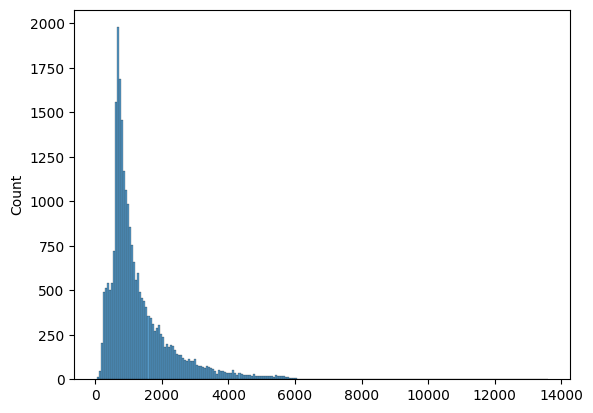

In [25]:
# char lengths
import seaborn as sns

num_chars = list(map(lambda x: len(x), train_ds['text']))
sns.histplot(num_chars)

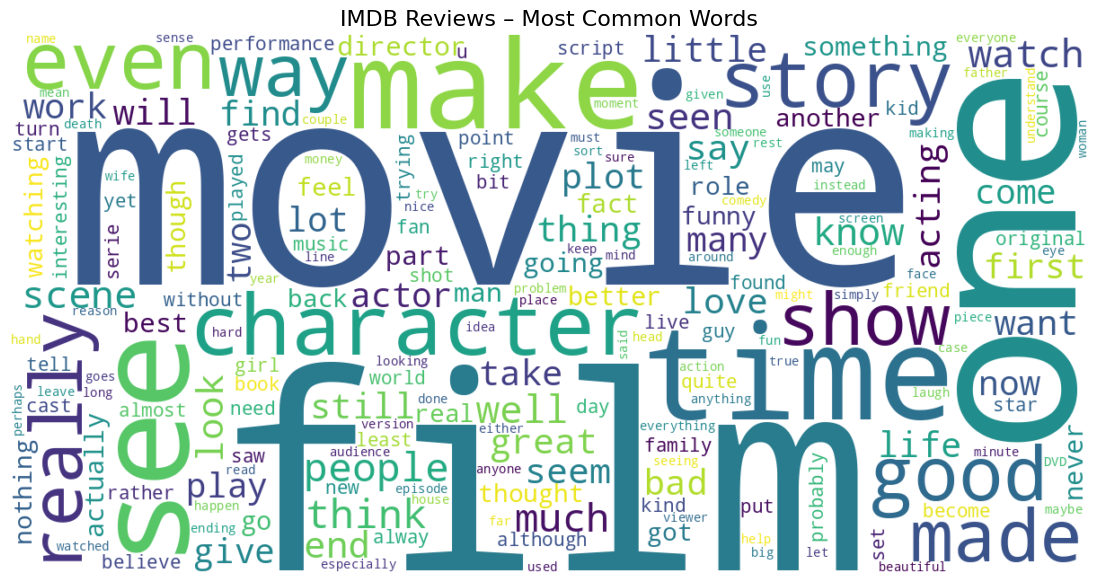

In [26]:
# word cloud plot
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

texts = train_ds["text"]

corpus = " ".join(texts)
len(corpus)

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
).generate(corpus)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("IMDB Reviews – Most Common Words", fontsize=16)
plt.show()

In [27]:
# train model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                max_features=50_000,
                ngram_range=(1, 2),
                stop_words="english"
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                n_jobs=-1
            ),
        ),
    ]
)


In [28]:
X_train = train_ds["text"]
y_train = train_ds["label"]

model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [29]:
from sklearn.metrics import accuracy_score, classification_report

X_test = test_ds["text"]
y_test = test_ds["label"]

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.88296
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [32]:
samples = [
    "This movie was an absolute masterpiece. I loved it.",
    "What a waste of time. The plot was boring and predictable."
]

print(model.predict_proba(samples))


[[0.15593281 0.84406719]
 [0.99189252 0.00810748]]


In [34]:
import joblib
from pathlib import Path

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
MODEL_PATH = ARTIFACT_DIR / "sentiment_model.joblib"
joblib.dump(model, MODEL_PATH)

print("Model saved!")

Model saved!


In [38]:
# load and apply

model = joblib.load(MODEL_PATH)
model.predict_proba([clean_text('I just thought this move was amazingly stupid. Quite astounding.')])

array([[0.6299056, 0.3700944]])